<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-TEP2-Base/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-9uhc7oj_
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-9uhc7oj_
  Created wheel for pyFTS: filename=pyFTS-1.6-py3-none-any.whl size=217208 sha256=0d8f817b2052fad5498e44b98c3bd687b172b8ce4daa26874afa44da9ea56f8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hqv8xwo/wheels/30/23/2b/2e10c811e284f08e37b5f6d6320e78bade4dd580081288f61a
Successfully built pyFTS
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 16.0 MB/s 
     |████████████████████████████████| 944 kB 71.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 426 kB 15.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached pycos-4.12.1-py3-none-any.whl
  Created wheel for dispy: filename=dispy-4.15.1-py3-none-any.whl size=213151 sha256=96fcff65caa5e83cb2775fa89ade74af863c428b0bd278c82948281e9bc06fc4
  Stored in directory: /root/.cache/pip/wheels/74/a9/a9/da60ca2929aa2f5df2ee4b19a3b509d5fad720442045da22d1
Successfully built dispy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 15.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependen

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing all the necessary libraries 
!pip install pyreadr
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score,f1_score
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
import datetime
from tensorflow.keras.utils import to_categorical
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 14.2 MB/s 


In [4]:
#reading train data in .R format
#a1 = np.loadtxt('../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/d00.dat')
#d_a1 = a1.transpose()
#a2 = np.loadtxt('../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/d04.dat')
#d_a2 = a2.transpose()
a1 = pd.read_csv("../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/test.csv")
#a2 = pd.read_csv("../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/train.csv")
a2 = pd.read_csv("../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/train_2.csv",delimiter=';')

#reading test data in .R format

#a3 = np.loadtxt('../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/d00_te.dat')
#d_a3 = a3.transpose()
#a4 = np.loadtxt('../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/d04_te.dat')
#d_a4 = a4.transpose()
#print("Objects that are present in a1 :",a1)
print(a2)
#print("Objects that are present in a3 :",d_a3)
#print("Objects that are present in a4 :",d_a4)

        faultNumber  simulationRun  sample  xmeas_6  xmeas_7  xmeas_8  xmeas_9
0               0.0            1.0       1   42.402   2704.3   74.863   120.41
1               0.0            1.0       2   42.576   2705.0   75.000   120.41
2               0.0            1.0       3   42.070   2706.2   74.771   120.42
3               0.0            1.0       4   42.063   2707.2   75.224   120.39
4               0.0            1.0       5   42.650   2705.1   75.388   120.39
...             ...            ...     ...      ...      ...      ...      ...
270395         20.0           24.0     496   42.017   2691.9   74.217   120.41
270396         20.0           24.0     497   41.935   2692.1   74.513   120.39
270397         20.0           24.0     498   42.475   2694.8   74.098   120.42
270398         20.0           24.0     499   42.480   2694.8   75.163   120.39
270399         20.0           24.0     500   42.351   2693.8   75.356   120.41

[270400 rows x 7 columns]


In [5]:
#REading the .Rdata files in pandas dataframe and saving it in .csv file
#reading train data
b1 = a1
b2 = a2
#b1 = a1['fault_free_training']
#b2 = a2['faulty_training']
#reading test data
#b3 = a3['fault_free_testing']
#b4 = a4['faulty_testing']

# concatinating the train and the test dataset
frames_tr = [b1]
train_ts = pd.concat(frames_tr)
frames_ts = [b2]
test = pd.concat(frames_ts)
#all_data_TEP = [train_ts,test]
#all_TEP = pd.concat(all_data_TEP)

In [6]:
print('Shape of the Train dataset:', train_ts.shape)
print("Shape of the Test dataset:", test.shape)

print("Distrubution of faults in train dataset:")
print(train_ts['faultNumber'].value_counts())

print("Distrubution of faults in test dataset:")
print(test['faultNumber'].value_counts())

Shape of the Train dataset: (104000, 56)
Shape of the Test dataset: (270400, 7)
Distrubution of faults in train dataset:
10    5000
11    5000
19    5000
18    5000
17    5000
16    5000
15    5000
14    5000
13    5000
12    5000
20    5000
1     5000
9     5000
8     5000
7     5000
6     5000
5     5000
4     5000
3     5000
2     5000
0     4000
Name: faultNumber, dtype: int64
Distrubution of faults in test dataset:
0.0     40000
11.0    11520
19.0    11520
18.0    11520
17.0    11520
16.0    11520
15.0    11520
14.0    11520
13.0    11520
12.0    11520
10.0    11520
1.0     11520
9.0     11520
8.0     11520
7.0     11520
6.0     11520
5.0     11520
4.0     11520
3.0     11520
2.0     11520
20.0    11520
Name: faultNumber, dtype: int64


       faultNumber  simulationRun  sample  xmeas_6  xmeas_7  xmeas_8  xmeas_9
74560          4.0            1.0      21   42.565   2701.1   75.094   120.57
74561          4.0            1.0      22   42.468   2699.9   74.901   120.45
74562          4.0            1.0      23   42.760   2699.2   74.634   120.45
74563          4.0            1.0      24   42.543   2698.9   74.671   120.42
74564          4.0            1.0      25   42.089   2699.9   75.592   120.43
...            ...            ...     ...      ...      ...      ...      ...
86075          4.0           24.0     496   42.652   2694.8   74.412   120.41
86076          4.0           24.0     497   42.269   2693.5   73.885   120.41
86077          4.0           24.0     498   42.423   2690.7   75.227   120.42
86078          4.0           24.0     499   42.100   2689.4   75.271   120.38
86079          4.0           24.0     500   42.582   2690.0   75.038   120.38

[11520 rows x 7 columns]
       faultNumber  simulationRun  sam

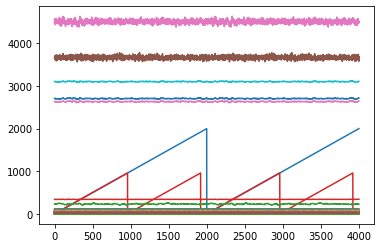

In [7]:
train_ts_2 = train_ts.loc[train_ts['faultNumber']==0]
train_ts_3 = train_ts_2.loc[train_ts_2['xmeas_1']==1]
test_2 = test.loc[test['faultNumber']==4] #funciona filtro dados
#test_2 = test_2[0:50000]
test_sf = test.loc[test['faultNumber']==0]
print(test_2)
print(test_sf)
plt.plot(train_ts_2)

In [8]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

In [9]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [10]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# Basic Libraries

import pyreadr

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.decomposition

sns.set()

Mounted at /content/drive


In [11]:
PATH = '../content/drive/MyDrive/DadosPWFTS/'

train_normal_path = PATH+'TEP_FaultFree_Training.RData'
train_faulty_path = PATH+'TEP_Faulty_Training.RData'

test_normal_path = PATH+'TEP_FaultFree_Testing.RData'
test_faulty_path = PATH+'TEP_Faulty_Testing (1).RData'

In [12]:
train_normal = pyreadr.read_r(train_normal_path)['fault_free_training']
train_faulty = pyreadr.read_r(train_faulty_path)['faulty_training']

test_normal = pyreadr.read_r(test_normal_path)['fault_free_testing']
test_faulty = pyreadr.read_r(test_faulty_path)['faulty_testing']

In [13]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

df_test = test_faulty[(test_faulty.simulationRun==1)&(test_faulty.faultNumber==1)].iloc[:,3:]

In [14]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

dff = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosFalha.xlsx')
dfn = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosNormais.xlsx')

dados_treino_Falha = dff[0:2300] 
dados_teste_Falha = dff[1800:2300]

dados_treino_Normal = dfn[0:1800] 
dados_teste_Normal = dfn[1500:1800]

print(test_2)
print(test_sf)

       faultNumber  simulationRun  sample  xmeas_6  xmeas_7  xmeas_8  xmeas_9
74560          4.0            1.0      21   42.565   2701.1   75.094   120.57
74561          4.0            1.0      22   42.468   2699.9   74.901   120.45
74562          4.0            1.0      23   42.760   2699.2   74.634   120.45
74563          4.0            1.0      24   42.543   2698.9   74.671   120.42
74564          4.0            1.0      25   42.089   2699.9   75.592   120.43
...            ...            ...     ...      ...      ...      ...      ...
86075          4.0           24.0     496   42.652   2694.8   74.412   120.41
86076          4.0           24.0     497   42.269   2693.5   73.885   120.41
86077          4.0           24.0     498   42.423   2690.7   75.227   120.42
86078          4.0           24.0     499   42.100   2689.4   75.271   120.38
86079          4.0           24.0     500   42.582   2690.0   75.038   120.38

[11520 rows x 7 columns]
       faultNumber  simulationRun  sam

## Analisando as Séries Temporais

In [34]:
#Dados sem Falhas

from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets1 = {}

#datasets1['LIT'] = dados_treino_Falha.get('LIT_2012KS_0251_FilteredSignal')
datasets1['LIT'] = df_train.get('xmv_3')
#datasets1['SpeedActual'] = dados_treino_Falha.get('_AL_2012KS_06M1_SpeedActual')
datasets1['SpeedActual'] = df_train.get('xmeas_3')###
#datasets1['BeltLoad'] = dados_treino_Falha.get('WIT_1085KS_2300_BeltLoad')
datasets1['BeltLoad'] = df_train.get('xmeas_19')
#datasets1['Rate'] = dados_treino_Falha.get('WIT_1085KS_2300_Rate')
datasets1['Rate'] = df_train.get('xmeas_20')

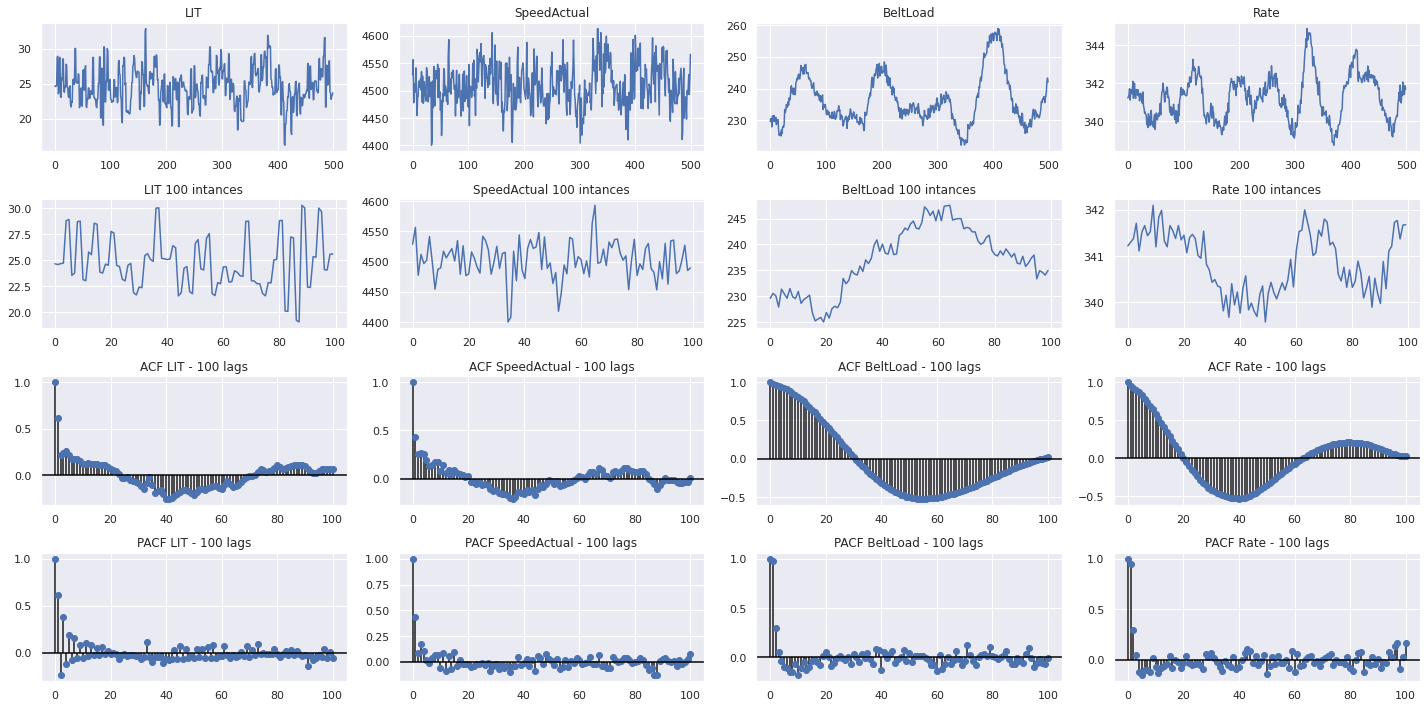

In [35]:
#Dados sem Falhas

fig1, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets1.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

In [36]:
#Dados normais - com falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets2 = {}

#datasets2['LIT'] = dados_treino_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets2['LIT'] = df_test.get('xmv_3')
#datasets2['SpeedActual'] = dados_treino_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets2['SpeedActual'] = df_test.get('xmeas_3')
#datasets2['BeltLoad'] = dados_treino_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets2['BeltLoad'] = df_test.get('xmeas_19')
#datasets2['Rate'] = dados_treino_Normal.get('WIT_1085KS_2300_Rate')
datasets2['Rate'] = df_test.get('xmeas_20')

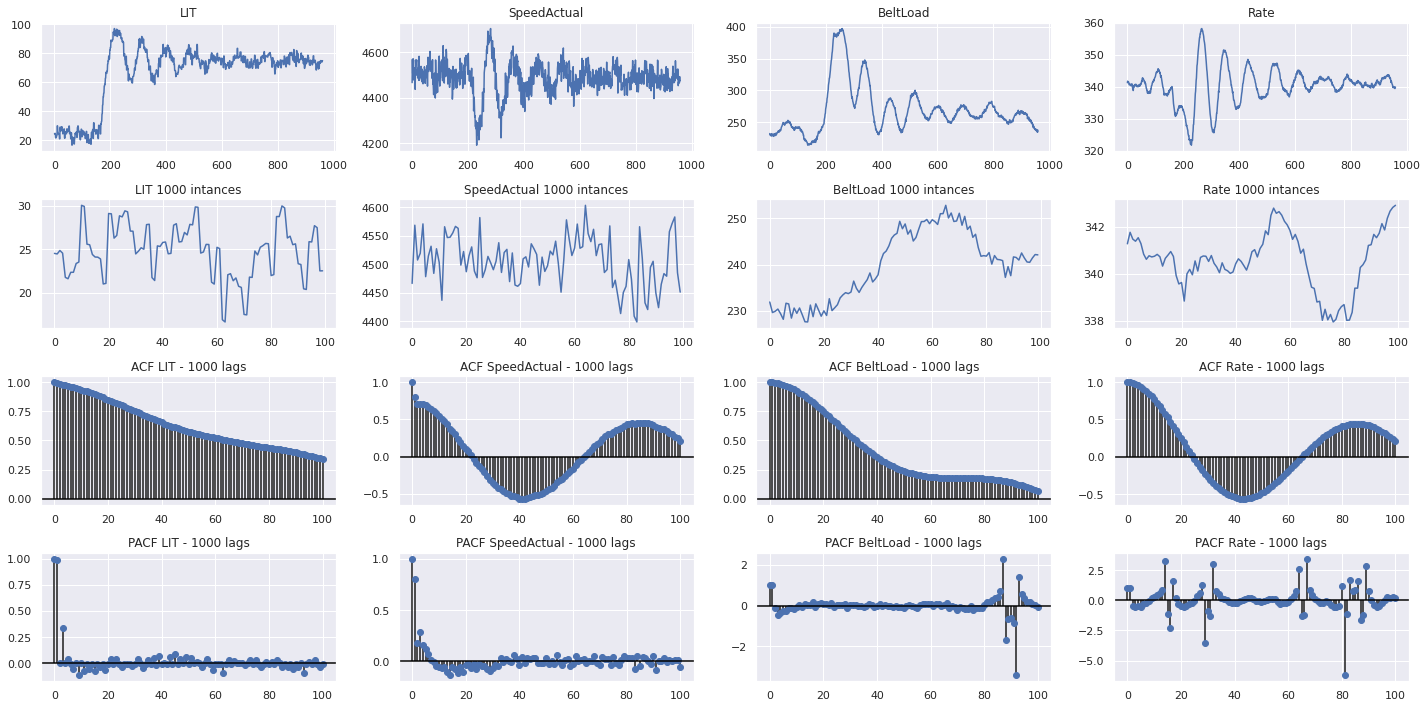

In [37]:
#Dados normais - com falhas

fig2, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets2.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 1000 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 1000 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 1000 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,Grid,39.54,0.71,0.96
1,Entropy,38.70,0.69,0.94
2,CMeans,38.69,0.69,0.94


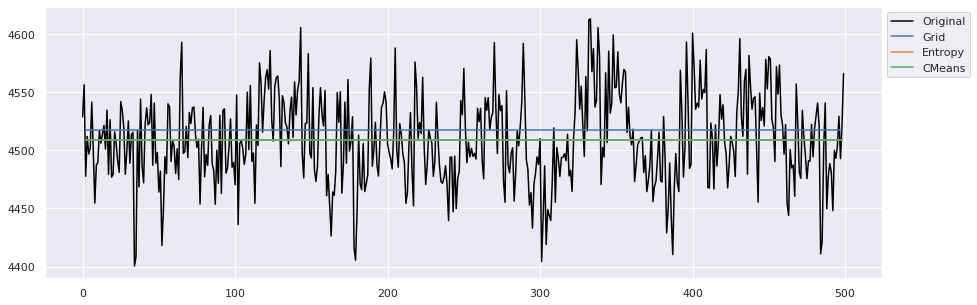

In [38]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]
#metodos = [Entropy.EntropyPartitioner]

k = 4

rows = []

y1=np.asarray(datasets1['SpeedActual'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y1, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y1, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y1)
  forecasts = model.predict(y1)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y1, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [41]:
#Dados Sem Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']
tam_grupo = 100
i=0
VT1=[]
V1=[] 

for i in range(0,y1.size,tam_grupo): 
  grpan = y1[i:i+tam_grupo]
  print(grpan)
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  print(part)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
   # model1.fit(np.asarray(data)) 
    model1.fit(np.asarray(y1))   
  print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VT1 = V1
  else:
    VT1 = np.c_[VT1,V1]

  print(VT1)
  print(i)

VT1 = np.transpose(VT1)
print(VT1)

0     24.657
1     24.588
2     24.666
3     24.725
4     28.797
       ...  
95    29.658
96    24.091
97    24.069
98    25.567
99    25.604
Name: xmv_3, Length: 100, dtype: float64
Grid:
A0: trimf([15.566319999999997, 17.1774, 18.78848])
A1: trimf([17.1774, 18.78848, 20.39956])
A2: trimf([18.78848, 20.39956, 22.010640000000002])
A3: trimf([20.39956, 22.010640000000002, 23.621720000000003])
A4: trimf([22.010640000000002, 23.621720000000003, 25.232800000000005])
A5: trimf([23.621720000000003, 25.232800000000005, 26.843880000000006])
A6: trimf([25.232800000000005, 26.843880000000006, 28.454960000000007])
A7: trimf([26.843880000000006, 28.454960000000007, 30.066040000000008])
A8: trimf([28.454960000000007, 30.066040000000008, 31.67712000000001])
A9: trimf([30.066040000000008, 31.67712000000001, 33.28820000000001])

Probabilistic FTS:
(0.004) A0 -> (0.242)A0, (0.315)A1, (0.058)A2, (0.151)A3, (0.234)A4
(0.03) A1 -> (0.036)A0, (0.37)A1, (0.181)A2, (0.059)A3, (0.092)A4, (0.107)A5, (0.08)A6,

In [ ]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']
tam_grupo = 100
i=0
VT2=[]
V2=[]
for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(data))  
  #  model2.fit(np.asarray(y2))  
  print(model2)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VT2 = V2
  else:
    VT2 = np.c_[VT2,V2]

  print(lhs2t)
  print(rhs2)
  print(i)

VT2 = np.transpose(VT2)
print(VT2)

Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 1.]]
0
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 1.]]
100
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 1.]]
200
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 1.]]
300
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 1.]]
400
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [ ]:
print(datasets1['BeltLoad'])

0      229.61
1      230.54
2      230.08
3      227.91
4      231.37
        ...  
495    237.65
496    239.06
497    242.23
498    243.30
499    242.08
Name: xmeas_19, Length: 500, dtype: float64


In [ ]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets1['BeltLoad']
tam_grupo = 100
i=0
VT3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  #grpan = test_sf.loc[test_sf['simulationRun'] == i+1]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(np.asarray(data)))
    #model3.fit(np.asarray(y3))  
  print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VT3 = V3
  else:
    VT3 = np.c_[VT3,V3]

  print(lhs3t)
  print(rhs3)
  print(i)

VT3 = np.transpose(VT3)
print(VT3)


Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
0
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
100
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
200
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
300
Probabilistic FTS:
(1.0) A4 -> (1.0)A4

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
400
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [ ]:
print(datasets2['Rate'])

0      341.27
1      341.76
2      341.47
3      341.38
4      341.53
        ...  
955    339.95
956    339.68
957    339.46
958    339.92
959    339.89
Name: xmeas_20, Length: 960, dtype: float64


In [ ]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets2['Rate']
tam_grupo = 100
i=0
VT4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VT4 = V4
  else:
    VT4 = np.c_[VT4,V4]

  print(lhs4t)
  print(rhs4)
  print(i)

VT4 = np.transpose(VT4)
print(VT4)

Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[0.14418078 0.14276369 0.14152234 0.14129537 0.14248034 0.14270265
 0.14505483]
[[0.14059391 0.15101926 0.14335893 0.14155142 0.14074458 0.14228024
  0.14045166]
 [0.14110998 0.14584546 0.1438836  0.14296361 0.14179766 0.14343337
  0.14096631]
 [0.14322271 0.14345807 0.14234713 0.14231872 0.14228557 0.14402416
  0.14234364]
 [0.14257158 0.14354264 0.14242991 0.14240146 0.14236825 0.14410964
  0.14257652]
 [0.14136239 0.14344676 0.14305178 0.14332652 0.14354942 0.14404469
  0.14121844]
 [0.14116096 0.14243011 0.14246357 0.14315847 0.14401519 0.14575448
  0.14101723]
 [0.1407262  0.14186562 0.14153692 0.1414182  0.14421285 0.14965543
  0.1405848 ]]
0
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[0.1397727  0.13994858 0.13521994 0.14092109 0.13612319 0.14900546
 0.15900905]
[[0.13882475 0.15989693 0.1443578  0.13917322 0.13888623 0.13958986
  0.13927121]
 [0.13766354 0.14475574 0.15800396 0.14468627 0.13835336 0.13842769
  0.13810945]
 [0.14247763 0.1436

In [ ]:
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']
#y1 = test_2
tam_grupo = 100
i=0
VU1=[]
V1 = []
for i in range(0,y1.size,tam_grupo):
#for i in range(20):  
  grpan = y1[i:i+tam_grupo]
  #grpan = test_2.loc[test_2['simulationRun'] == i+1]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))
    #model1.fit(np.asarray(data))  
  print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VU1 = V1
  else:
    VU1 = np.c_[VU1,V1]

  print(lhs1t)
  print(rhs1)
  print(i)

VU1 = np.transpose(VU1)
print(VU1)


Probabilistic FTS:
(0.045) A4 -> (0.096)A4, (0.904)A5, (0.0)A6
(0.928) A5 -> (0.044)A4, (0.93)A5, (0.027)A6
(0.027) A6 -> (0.001)A4, (0.906)A5, (0.093)A6

[0.04477074 0.9277745  0.02745477]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.55423303e-02 9.04100464e-01 3.57206058e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.36537177e-02 9.29528945e-01 2.68173377e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.51481781e-04 9.06065013e-01 9.31835054e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
0
Probabilistic FTS:
(0.042) A4 -> (0.093)A4, (0.907)A5, (0.0)A6
(0.929) A5 -> (0.041)A4, (0.93)A5, (0.029)A6
(0.029) A6 -> (0.001)A4, (0.903)A5, (0.096)A6

[0.04192713 0.92871557 0.02935731]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.27040708e-02 9.06967991e-01 3.27938069e-04 0.00000000e+00
  0.00000000e+00 0.000

In [ ]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']
tam_grupo = 100
i=0
VU2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  print(model2)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VU2 = V2
  else:
    VU2 = np.c_[VU2,V2]

  print(lhs2t)
  print(rhs2)
  print(i)

VU2 = np.transpose(VU2)
print(VU2)

Probabilistic FTS:
(0.139) A0 -> (0.142)A0, (0.147)A1, (0.142)A2, (0.142)A3, (0.142)A4, (0.145)A5, (0.142)A6
(0.152) A1 -> (0.134)A0, (0.182)A1, (0.146)A2, (0.134)A3, (0.134)A4, (0.137)A5, (0.134)A6
(0.145) A2 -> (0.136)A0, (0.153)A1, (0.16)A2, (0.141)A3, (0.136)A4, (0.139)A5, (0.136)A6
(0.141) A3 -> (0.139)A0, (0.144)A1, (0.144)A2, (0.147)A3, (0.144)A4, (0.143)A5, (0.139)A6
(0.141) A4 -> (0.139)A0, (0.145)A1, (0.141)A2, (0.144)A3, (0.145)A4, (0.147)A5, (0.139)A6
(0.144) A5 -> (0.14)A0, (0.145)A1, (0.14)A2, (0.141)A3, (0.144)A4, (0.15)A5, (0.14)A6
(0.139) A6 -> (0.142)A0, (0.147)A1, (0.142)A2, (0.142)A3, (0.142)A4, (0.145)A5, (0.142)A6

[0.15192182 0.14484374 0.13862517 0.13862517 0.14123931 0.14076831
 0.14397648]
[[0.13368302 0.18243401 0.14622203 0.13368302 0.1337247  0.1365702
  0.13368302]
 [0.1356794  0.15313063 0.15984282 0.14073674 0.13622334 0.13870767
  0.1356794 ]
 [0.14159157 0.1470696  0.14176277 0.14159157 0.14163724 0.14475568
  0.14159157]
 [0.14159157 0.1470696  0.1417

In [ ]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets1['BeltLoad']
tam_grupo = 100
i=0
VU3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  print(model3)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VU3 = V3
  else:
    VU3 = np.c_[VU3,V3]

  print(lhs3t)
  print(rhs3)
  print(i)

VU3 = np.transpose(VU3)
print(VU3)

Probabilistic FTS:
(0.134) A0 -> (0.15)A0, (0.152)A1, (0.139)A2, (0.137)A3, (0.138)A4, (0.144)A5, (0.14)A6
(0.167) A1 -> (0.121)A0, (0.235)A1, (0.162)A2, (0.119)A3, (0.119)A4, (0.124)A5, (0.12)A6
(0.151) A2 -> (0.122)A0, (0.178)A1, (0.191)A2, (0.141)A3, (0.122)A4, (0.125)A5, (0.121)A6
(0.141) A3 -> (0.131)A0, (0.143)A1, (0.152)A2, (0.165)A3, (0.143)A4, (0.137)A5, (0.129)A6
(0.135) A4 -> (0.136)A0, (0.146)A1, (0.136)A2, (0.147)A3, (0.147)A4, (0.153)A5, (0.134)A6
(0.138) A5 -> (0.137)A0, (0.147)A1, (0.134)A2, (0.135)A3, (0.145)A4, (0.167)A5, (0.135)A6
(0.134) A6 -> (0.14)A0, (0.15)A1, (0.138)A2, (0.135)A3, (0.136)A4, (0.142)A5, (0.158)A6

[0.16698321 0.15085835 0.13407788 0.14050453 0.1352275  0.13410139
 0.13824715]
[[0.12144942 0.2345438  0.16247007 0.11925373 0.1185884  0.12350952
  0.12018506]
 [0.12210856 0.17821897 0.19134723 0.14130585 0.12171368 0.12459665
  0.12070906]
 [0.14980415 0.15210133 0.13916066 0.13700632 0.13793183 0.14406803
  0.13992768]
 [0.13076752 0.14310012 0.151

In [ ]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets1['Rate']
tam_grupo = 100
i=0
VU4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  print(model4)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VU4 = V4
  else:
    VU4 = np.c_[VU4,V4]

  print(lhs4t)
  print(rhs4)
  print(i)

VU4 = np.transpose(VU4)
print(VU4)

Probabilistic FTS:
(0.138) A0 -> (0.139)A0, (0.146)A1, (0.142)A2, (0.142)A3, (0.145)A4, (0.147)A5, (0.139)A6
(0.146) A1 -> (0.138)A0, (0.148)A1, (0.146)A2, (0.143)A3, (0.143)A4, (0.144)A5, (0.138)A6
(0.144) A2 -> (0.137)A0, (0.148)A1, (0.146)A2, (0.144)A3, (0.143)A4, (0.144)A5, (0.137)A6
(0.142) A3 -> (0.136)A0, (0.146)A1, (0.145)A2, (0.146)A3, (0.144)A4, (0.146)A5, (0.136)A6
(0.144) A4 -> (0.137)A0, (0.144)A1, (0.142)A2, (0.144)A3, (0.147)A4, (0.148)A5, (0.137)A6
(0.148) A5 -> (0.138)A0, (0.144)A1, (0.141)A2, (0.143)A3, (0.146)A4, (0.15)A5, (0.138)A6
(0.138) A6 -> (0.139)A0, (0.146)A1, (0.142)A2, (0.142)A3, (0.145)A4, (0.147)A5, (0.139)A6

[0.14385837 0.14606952 0.14222649 0.13801641 0.13801641 0.14411181
 0.14770099]
[[0.13677687 0.1483564  0.14630935 0.14435678 0.14310578 0.14431796
  0.13677687]
 [0.1377077  0.14784066 0.1461118  0.14276722 0.14336722 0.14449771
  0.1377077 ]
 [0.13641334 0.14611024 0.14470561 0.14563259 0.14442669 0.14629819
  0.13641334]
 [0.1394078  0.14600632 0

In [ ]:
ytst1 = np.ones(80)
ytst2 = np.zeros(80)
ytst = np.concatenate((ytst1,ytst2))

In [ ]:
#Unir todas as matrizes geradas
BaseT1 = np.transpose(np.concatenate([np.transpose(VT1),np.transpose(VT2),np.transpose(VT3)]))
BaseT2 = np.transpose(np.concatenate([np.transpose(VU1),np.transpose(VU2),np.transpose(VU3)]))
BaseT3 = np.c_[np.transpose(BaseT1), np.transpose(BaseT2)]
BaseT4 = np.c_[np.transpose(BaseT3),ytst]

ValueError: ignored

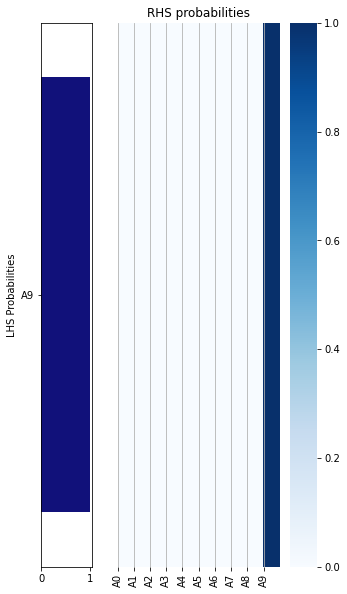

In [ ]:
pwfts.visualize_distributions(model1)

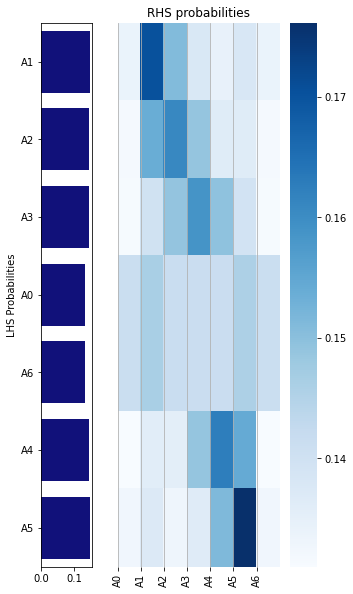

In [ ]:
pwfts.visualize_distributions(model2)

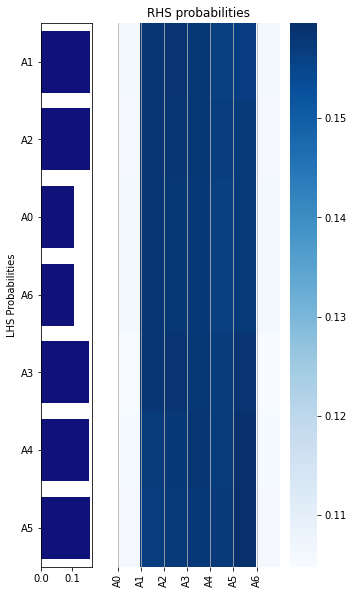

In [ ]:
pwfts.visualize_distributions(model3)

ValueError: ignored

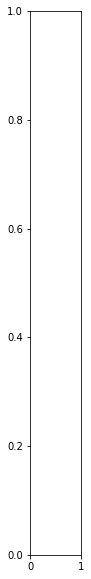

In [ ]:
pwfts.visualize_distributions(model4)

In [ ]:
#dataset = pd.read_excel('../content/sample_data/Base.xlsx')
#x = dataset.iloc[:,:-1].values
#y = dataset.iloc[:,-1].values
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

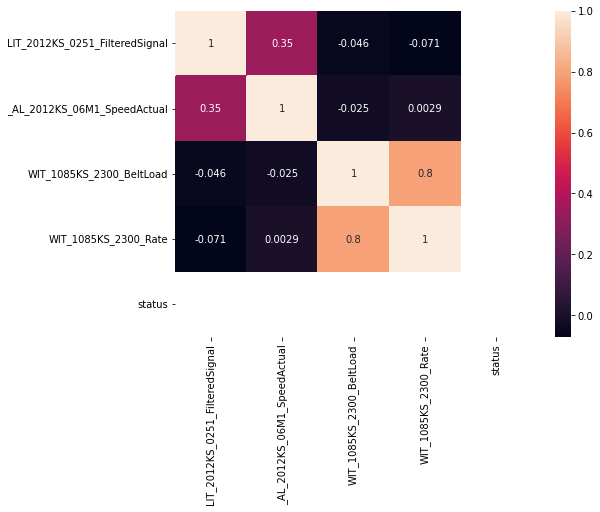

In [ ]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dff.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

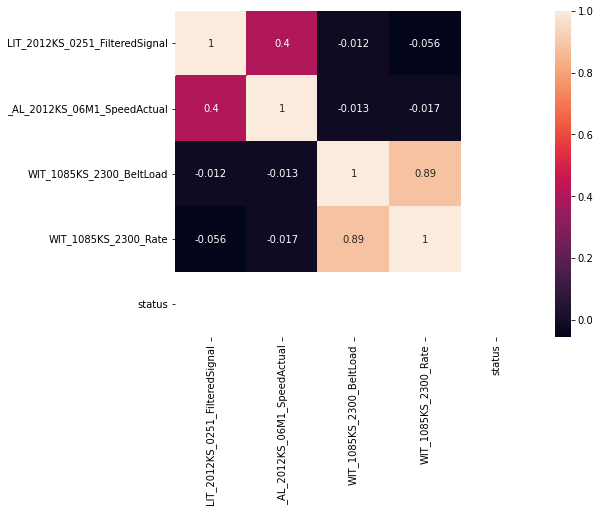

In [ ]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dfn.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [ ]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[ 6  9]
 [13  4]]


Precisão

In [ ]:
accuracy_score(y_test, ypred)

0.3125

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 2)

print(accuracies.mean()*100)
print(accuracies.std()*100)

43.75
3.125
